In [1]:
%load_ext autoreload
%autoreload 2

# Analysis 2
This analysis was edited from the *opynfield* tutorial. Here, we are comparing two groups of Canton-S flies that were run in different sized arenas. We expect that flies in the larger arenas will explore more as a function of time, but the same as a function of coverage.

## 1. Import the package and needed functions / classes

In [2]:
from opynfield.config.user_input import UserInput
from opynfield.config.defaults_settings import Defaults
from opynfield.config.cov_asymptote import CoverageAsymptote
from opynfield.config.model_settings import set_up_fits
from opynfield.config.plot_settings import PlotSettings
from opynfield.readin.run_all import run_all_track_types
from opynfield.calculate_measures.calculate_measures import tracks_to_measures
from opynfield.summarize_measures.summarize_individuals import individual_measures_to_dfs
from opynfield.summarize_measures.summarize_groups import all_group_averages
from opynfield.fit_models.fit_individual_models import fit_all, find_fit_bounds, re_fit_all
from opynfield.fit_models.fit_group_models import group_fit_all
from opynfield.stat_test.stat_test import format_params, format_group_params, run_tests
from opynfield.plotting.plot_individuals import plot_all_individuals, plot_traces
from opynfield.plotting.plot_solo_groups import plot_all_solo_groups
from opynfield.plotting.plot_solo_groups_with_individuals import plot_components_of_solo_groups
from opynfield.plotting.plot_group_comparisons import plot_all_group_comparisons
from opynfield.readin.summary_file import summary_file

from dataclasses import dataclass
import numpy as np
from copy import deepcopy

import matplotlib.pyplot as plt

## 2. Define the settings to use

### 2a. Set up your user inputs
The data we have for these groups is in text file format. They were originally recorded (and smoothed) in Ethovision, before the raw coordinates were extracted using a MATLAB Program. Since arena size is defined at the UserInput level, we will create two sets of parameters to read in the groups separately, and combine them later.

For the first group, in 5.0cm diameter arenas, we set the name, filetype, arena radius, and edge distance. We set the edge distance to 2.5/4.2 so that the edge region takes up proportionally the same amount of the arena radisu as the 1cm edge region does in the 4.2cm radius arena. All other settings are kept the same as in Analysis 1.

For the second group, in the standard 8.4cm diameter arenas, we set the name and filetype. All other settings are kept the same as in Analysis 1.

user_settings1 and user_settings2 will be used to read in the files and calculate behavioral measures. Later, we will need a unified set, user_settings, that includes both groups in order to loop through the groups for plotting and other analyses.

In [3]:
user_settings1 = UserInput(groups_and_types = {"5.0": ["Ethovision Through MATLAB"]},
                          groups_to_paths = {"5.0": "5.0"},
                          arena_radius_cm = 2.5,
                          sample_freq = 30,
                          edge_dist_cm = 2.5/4.2, # this is to keep the proportion of the arena that is in the edge region constant (see below)
                          time_bin_size = 1,
                          inactivity_threshold = 0.001,
                          verbose = True,
                          result_path = '/Users/ellenmcmullen/Desktop/opynfield_v3_analysis_files/Analysis2/ExpectedResultsAnalysis2')
user_settings2 = UserInput(groups_and_types = {"8.4": ["Ethovision Through MATLAB"]},
                          groups_to_paths = {"8.4": "8.4"},
                          arena_radius_cm = 4.2,
                          sample_freq = 30,
                          edge_dist_cm = 1, # 1cm is the normal edge size for a 8.4cm arena 1/8.4 = x/5.0, x = 5/8.4 = 2.5/4.2
                          time_bin_size = 1,
                          inactivity_threshold = 0.001,
                          verbose = True,
                          result_path = '/Users/ellenmcmullen/Desktop/opynfield_v3_analysis_files/Analysis2/ExpectedResultsAnalysis2')
user_settings = UserInput(groups_and_types = {"5.0": ["Ethovision Through MATLAB"], "8.4": ["Ethovision Through MATLAB"]},
                          groups_to_paths = {"5.0": "5.0", "8.4": "8.4"},
                          arena_radius_cm = 9999, #should be obvious if this is propogated somewhere
                          sample_freq = 30,
                          edge_dist_cm = 1,
                          time_bin_size = 1,
                          inactivity_threshold = 0.001,
                          verbose = True,
                          result_path = '/Users/ellenmcmullen/Desktop/opynfield_v3_analysis_files/Analysis2/ExpectedResultsAnalysis2')

### 2b. Prep the results directory

In [4]:
user_settings.prep_directory()

### 2c. Set up the default settings

In [5]:
default_settings = Defaults()

In [6]:
default_settings.time_averaged_measures = ['activity', 'coverage', 'percent_coverage',
                                            'p_plus_plus_given_plus', 'p_plus_minus_given_plus', 'p_plus_zero_given_plus',
                                            'p_zero_plus_given_zero', 'p_zero_zero_given_zero']
default_settings.coverage_averaged_measures = ['activity',
                                                'p_plus_plus_given_plus', 'p_plus_minus_given_plus', 'p_plus_zero_given_plus',
                                                'p_zero_plus_given_zero', 'p_zero_zero_given_zero']

### 2d. Set up the coverage asymptote settings

In [7]:
asymptote_settings = CoverageAsymptote()

### 2e. Set up the model settings

In [8]:
model_settings = set_up_fits()

In [9]:
@dataclass()
class SigmoidDecayModel:
    initial_params: tuple[float, float, float] = (1, -0.1, -10)
    bounds: tuple[tuple[float, float, float], tuple[float, float, float]] = (
        (0, -10, -100),
        (10, 0, 0),
    )
    max_eval: int = 4000
    display_parts: tuple[str] = ("y = ", " / (1 + np.exp(-", " * (x + ", ")))")

    @staticmethod
    def model_function(x, a, b, c):
        # Exponential Implementation
        y = a / (1 + np.exp(-b * (x + c)))
        return y

In [10]:
@dataclass()
class SigmoidIncreaseModel:
    initial_params: tuple[float, float, float] = (1, 0.1, -10)
    bounds: tuple[tuple[float, float, float], tuple[float, float, float]] = (
        (0, 0, -100),
        (10, 10, 0),
    )
    max_eval: int = 4000
    display_parts: tuple[str] = ("y = ", " / (1 + np.exp(-", " * (x + ", ")))")

    @staticmethod
    def model_function(x, a, b, c):
        # Exponential Implementation
        y = a / (1 + np.exp(-b * (x + c)))
        return y

In [11]:
model_settings['percent_coverage']['p_plus_plus_given_plus'].model = SigmoidDecayModel
model_settings['percent_coverage']['p_plus_minus_given_plus'].model = SigmoidIncreaseModel
model_settings['percent_coverage']['p_plus_zero_given_plus'].model = SigmoidIncreaseModel
model_settings['percent_coverage']['p_zero_plus_given_zero'].model = SigmoidDecayModel
model_settings['percent_coverage']['p_zero_zero_given_zero'].model = SigmoidIncreaseModel

Sometimes the models fail to converge on the first attempt. You can go back to the model settings and update the max_eval parameter for the relationships that are causing problems like this:

In [12]:
for key in model_settings['percent_coverage']:
    model_settings['percent_coverage'][key].model.max_eval = 10000

### 2f. Set up the plotting settings

In [13]:
plot_settings = PlotSettings(group_colors={'5.0': 'b', '8.4': 'r'}, fig_extension='.svg')

## 3. Read in your data
Here, we need to read in the two groups separately, so that we can apply their specific user_settings to them. Then we combine the list of tracks.

In [14]:
track_list1 = run_all_track_types(groups_and_types=user_settings1.groups_and_types,
                                 verbose=user_settings1.verbose,
                                 arena_radius_cm=user_settings1.arena_radius_cm,
                                 running_window_length=user_settings1.running_window_length,
                                 window_step_size=user_settings1.window_step_size,
                                 sample_freq=user_settings1.sample_freq,
                                 time_bin_size=user_settings1.time_bin_size,
                                 trim=user_settings1.trim)
track_list2 = run_all_track_types(groups_and_types=user_settings2.groups_and_types,
                                 verbose=user_settings2.verbose,
                                 arena_radius_cm=user_settings2.arena_radius_cm,
                                 running_window_length=user_settings2.running_window_length,
                                 window_step_size=user_settings2.window_step_size,
                                 sample_freq=user_settings2.sample_freq,
                                 time_bin_size=user_settings2.time_bin_size,
                                 trim=user_settings2.trim)
track_list = track_list1 + track_list2

['Ethovision Through MATLAB']
{'Ethovision Through MATLAB': ['5.0']}
Read In Ethovision Through MATLAB Files For Groups ['5.0']
Running Ethovision ML Tracker Files For Group: 5.0
5.0, File1 Out Of 136
Etho ML Track Converted To Numeric
Etho ML Track Subsampled
Etho ML Track Missing Values Filled
Combined Coordinate Center Point Calculated
Etho ML Track Centered
5.0, File2 Out Of 136
Etho ML Track Converted To Numeric
Etho ML Track Subsampled
Etho ML Track Missing Values Filled
Combined Coordinate Center Point Calculated
Etho ML Track Centered
5.0, File3 Out Of 136
Etho ML Track Converted To Numeric
Etho ML Track Subsampled
Etho ML Track Missing Values Filled
Combined Coordinate Center Point Calculated
Etho ML Track Centered
5.0, File4 Out Of 136
Etho ML Track Converted To Numeric
Etho ML Track Subsampled
Etho ML Track Missing Values Filled
Combined Coordinate Center Point Calculated
Etho ML Track Centered
5.0, File5 Out Of 136
Etho ML Track Converted To Numeric
Etho ML Track Subsampled

In [15]:
# trim some tracks down to 10min if they went over
for track in track_list:
    if len(track.x) >= 600:
        track.x = track.x[0:600]
        track.y = track.y[0:600]
        track.t = track.t[0:600]

## 4. Calculate behavioral measures

### 4a. Generate the measures
Now we convert the two groups to standard tracks separately, and then combine the resultant lists. We also set the tracks_by_groups dictionary up with the group labels.

In [16]:
standard_track_list1, tracks_by_groups1 = tracks_to_measures(all_tracks=track_list1,
                                                           user_config=user_settings1,
                                                           default_settings=default_settings,
                                                           coverage_settings=asymptote_settings)
standard_track_list2, tracks_by_groups2 = tracks_to_measures(all_tracks=track_list2,
                                                           user_config=user_settings2,
                                                           default_settings=default_settings,
                                                           coverage_settings=asymptote_settings)
standard_track_list = standard_track_list1 + standard_track_list2
tracks_by_groups = {"5.0": standard_track_list1, "8.4": standard_track_list2}

Polar Coordinates Calculated
Activity Calculated
Turning Angles Calculated
Motion Probabilities Calculated
Coverage Bins Located
Coverage Calculated
Percent Coverage Calculated
PICA Calculated
Polar Coordinates Calculated
Activity Calculated
Turning Angles Calculated
Motion Probabilities Calculated
Coverage Bins Located
Coverage Calculated
Percent Coverage Calculated
PICA Calculated
Polar Coordinates Calculated
Activity Calculated
Turning Angles Calculated
Motion Probabilities Calculated
Coverage Bins Located
Coverage Calculated
Percent Coverage Calculated
PICA Calculated
Polar Coordinates Calculated
Activity Calculated
Turning Angles Calculated
Motion Probabilities Calculated
Coverage Bins Located
Coverage Calculated
Percent Coverage Calculated
PICA Calculated
Polar Coordinates Calculated
Activity Calculated
Turning Angles Calculated
Motion Probabilities Calculated
Coverage Bins Located
Coverage Calculated
Percent Coverage Calculated
PICA Calculated
Polar Coordinates Calculated
Activi

/Users/ellenmcmullen/Desktop/opynfield_v3_analysis_files/opynfield/src/opynfield/calculate_measures/calculate_measures.py:286: RuntimeWarning: invalid value encountered in divide
  perc_cov = cov / highest_cov
/Users/ellenmcmullen/Desktop/opynfield_v3_analysis_files/opynfield/src/opynfield/calculate_measures/calculate_measures.py:286: RuntimeWarning: invalid value encountered in divide
  perc_cov = cov / highest_cov


Coverage Bins Located
Coverage Calculated
Percent Coverage Calculated
PICA Calculated
Polar Coordinates Calculated
Activity Calculated
Turning Angles Calculated
Motion Probabilities Calculated
Coverage Bins Located
Coverage Calculated
Percent Coverage Calculated
PICA Calculated
Polar Coordinates Calculated
Activity Calculated
Turning Angles Calculated
Motion Probabilities Calculated
Coverage Bins Located
Coverage Calculated
Percent Coverage Calculated
PICA Calculated
Polar Coordinates Calculated
Activity Calculated
Turning Angles Calculated
Motion Probabilities Calculated
Coverage Bins Located
Coverage Calculated
Percent Coverage Calculated
PICA Calculated
Polar Coordinates Calculated
Activity Calculated
Turning Angles Calculated
Motion Probabilities Calculated
Coverage Bins Located
Coverage Calculated
Percent Coverage Calculated
PICA Calculated
Polar Coordinates Calculated
Activity Calculated
Turning Angles Calculated
Motion Probabilities Calculated
Coverage Bins Located
Coverage Calc

/Users/ellenmcmullen/Desktop/opynfield_v3_analysis_files/opynfield/src/opynfield/calculate_measures/calculate_measures.py:286: RuntimeWarning: invalid value encountered in divide
  perc_cov = cov / highest_cov


PICA Calculated
Polar Coordinates Calculated
Activity Calculated
Turning Angles Calculated
Motion Probabilities Calculated
Coverage Bins Located
Coverage Calculated
Percent Coverage Calculated
PICA Calculated
Polar Coordinates Calculated
Activity Calculated
Turning Angles Calculated
Motion Probabilities Calculated
Coverage Bins Located
Coverage Calculated
Percent Coverage Calculated
PICA Calculated
Polar Coordinates Calculated
Activity Calculated
Turning Angles Calculated
Motion Probabilities Calculated
Coverage Bins Located
Coverage Calculated
Percent Coverage Calculated
PICA Calculated
Polar Coordinates Calculated
Activity Calculated
Turning Angles Calculated
Motion Probabilities Calculated
Coverage Bins Located
Coverage Calculated
Percent Coverage Calculated
PICA Calculated
Polar Coordinates Calculated
Activity Calculated
Turning Angles Calculated
Motion Probabilities Calculated
Coverage Bins Located
Coverage Calculated
Percent Coverage Calculated
PICA Calculated
Polar Coordinates C

### 4b. Save the measures

In [17]:
individual_dfs = individual_measures_to_dfs(tracks_by_groups=tracks_by_groups,
                                            defaults=default_settings,
                                            user_inputs=user_settings)

Summarizing Tracks From Group 5.0
Summarizing Tracks From Group 8.4


### 4c. Calculate group averages of the measures

In [18]:
group_averages = all_group_averages(individual_measures_dfs=individual_dfs,
                                    test_defaults=default_settings,
                                    user_config=user_settings)

Averaging Tracks From Group 5.0 by time
Averaging Tracks From Group 8.4 by time
Averaging Tracks From Group 5.0 By coverage
Averaging Tracks From Group 8.4 By coverage
Averaging Tracks From Group 5.0 By pica
Averaging Tracks From Group 8.4 By pica
Averaging Tracks From Group 5.0 By pgca
Averaging Tracks From Group 8.4 By pgca
Averaging Tracks From Group 5.0 by percent coverage
Averaging Tracks From Group 8.4 by percent coverage


We can check out the plots of group averages to check that we specified the correct models.

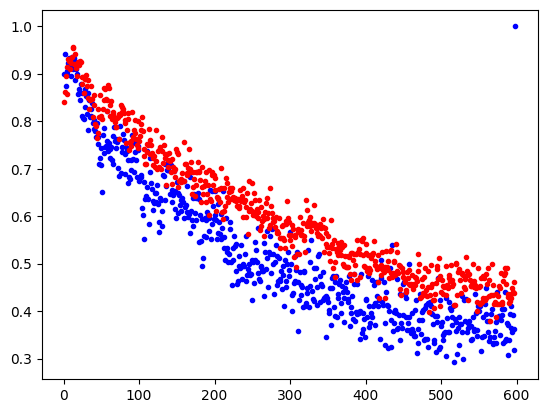

In [19]:
plt.plot(group_averages['time']['5.0']['p_plus_plus_given_plus'].iloc[0][2:602], 'b.')
plt.plot(group_averages['time']['8.4']['p_plus_plus_given_plus'].iloc[0][2:602], 'r.')
plt.show()

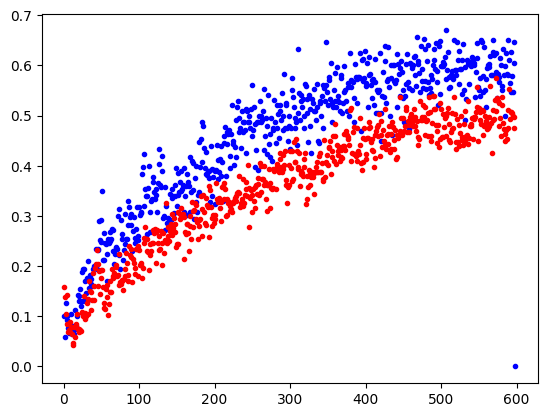

In [20]:
plt.plot(group_averages['time']['5.0']['p_plus_minus_given_plus'].iloc[0][2:602], 'b.')
plt.plot(group_averages['time']['8.4']['p_plus_minus_given_plus'].iloc[0][2:602], 'r.')
plt.show()

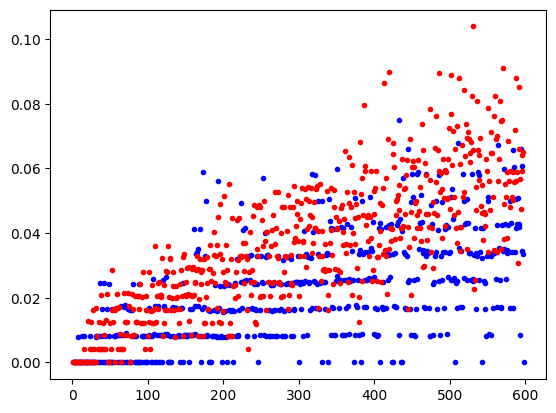

In [21]:
plt.plot(group_averages['time']['5.0']['p_plus_zero_given_plus'].iloc[0][2:602], 'b.')
plt.plot(group_averages['time']['8.4']['p_plus_zero_given_plus'].iloc[0][2:602], 'r.')
plt.show()

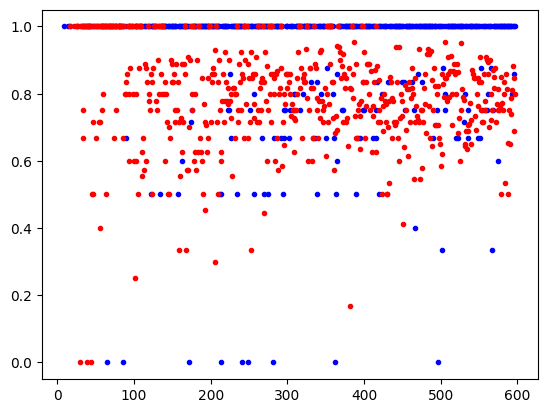

In [22]:
plt.plot(group_averages['time']['5.0']['p_zero_plus_given_zero'].iloc[0][2:602], 'b.')
plt.plot(group_averages['time']['8.4']['p_zero_plus_given_zero'].iloc[0][2:602], 'r.')
plt.show()

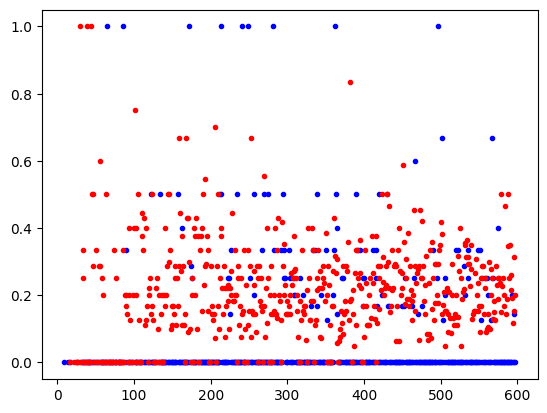

In [23]:
plt.plot(group_averages['time']['5.0']['p_zero_zero_given_zero'].iloc[0][2:602], 'b.')
plt.plot(group_averages['time']['8.4']['p_zero_zero_given_zero'].iloc[0][2:602], 'r.')
plt.show()

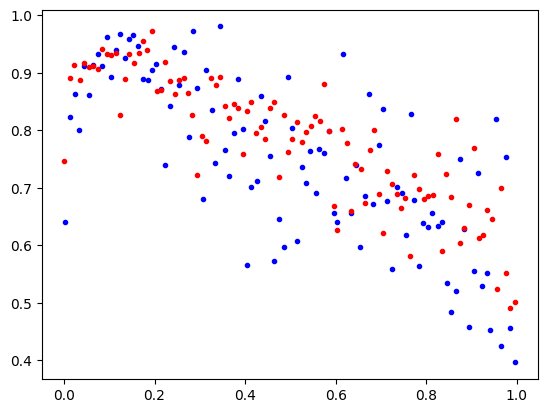

In [24]:
plt.plot(group_averages['percent_coverage']['5.0']['percent_coverage mean'],
         group_averages['percent_coverage']['5.0']['p_plus_plus_given_plus mean'], 'b.')
plt.plot(group_averages['percent_coverage']['8.4']['percent_coverage mean'],
         group_averages['percent_coverage']['8.4']['p_plus_plus_given_plus mean'], 'r.')
plt.show()

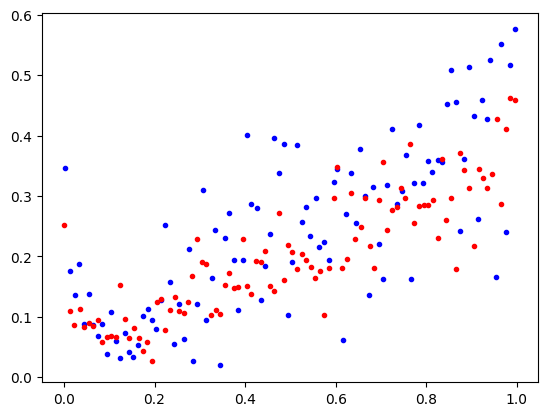

In [25]:
plt.plot(group_averages['percent_coverage']['5.0']['percent_coverage mean'],
         group_averages['percent_coverage']['5.0']['p_plus_minus_given_plus mean'], 'b.')
plt.plot(group_averages['percent_coverage']['8.4']['percent_coverage mean'],
         group_averages['percent_coverage']['8.4']['p_plus_minus_given_plus mean'], 'r.')
plt.show()

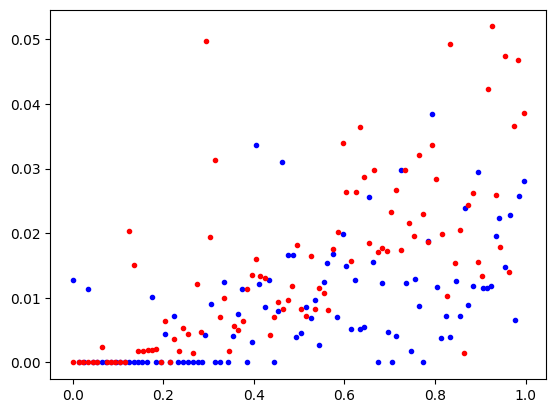

In [26]:
plt.plot(group_averages['percent_coverage']['5.0']['percent_coverage mean'],
         group_averages['percent_coverage']['5.0']['p_plus_zero_given_plus mean'], 'b.')
plt.plot(group_averages['percent_coverage']['8.4']['percent_coverage mean'],
         group_averages['percent_coverage']['8.4']['p_plus_zero_given_plus mean'], 'r.')
plt.show()

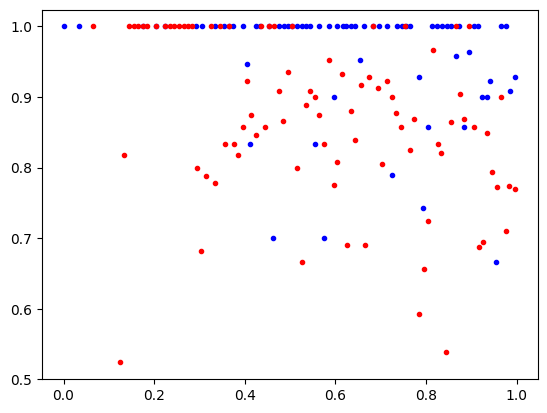

In [27]:
plt.plot(group_averages['percent_coverage']['5.0']['percent_coverage mean'],
         group_averages['percent_coverage']['5.0']['p_zero_plus_given_zero mean'], 'b.')
plt.plot(group_averages['percent_coverage']['8.4']['percent_coverage mean'],
         group_averages['percent_coverage']['8.4']['p_zero_plus_given_zero mean'], 'r.')
plt.show()

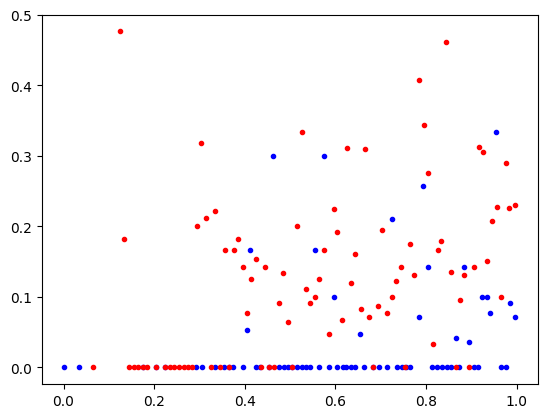

In [28]:
plt.plot(group_averages['percent_coverage']['5.0']['percent_coverage mean'],
         group_averages['percent_coverage']['5.0']['p_zero_zero_given_zero mean'], 'b.')
plt.plot(group_averages['percent_coverage']['8.4']['percent_coverage mean'],
         group_averages['percent_coverage']['8.4']['p_zero_zero_given_zero mean'], 'r.')
plt.show()

## 5. Fit models to individuals' measures


### 5a. Naive bounds

In [29]:
naive_fits = fit_all(individual_measures_dfs=individual_dfs,
                     defaults=default_settings,
                     model_params=model_settings)

Fitting Models To Tracks From Group 5.0 by time
Fitting Models To Tracks From Group 5.0 by coverage
Fitting Models To Tracks From Group 5.0 by pica
Fitting Models To Tracks From Group 5.0 by pgca
Fitting Models To Tracks From Group 5.0 by percent_coverage
Fitting Models To Tracks From Group 8.4 by time
Fitting Models To Tracks From Group 8.4 by coverage
Fitting Models To Tracks From Group 8.4 by pica
Fitting Models To Tracks From Group 8.4 by pgca
Fitting Models To Tracks From Group 8.4 by percent_coverage


### 5b. Find new bounds

In [30]:
upper_bounds, lower_bounds, p0s = find_fit_bounds(fits=naive_fits,
                                                  user_inputs=user_settings)

### 5c. Re-fit models

In [31]:
bounded_fits = re_fit_all(individual_measures_dfs=individual_dfs,
                          defaults=default_settings,
                          model_params=model_settings,
                          upper=upper_bounds,
                          lower=lower_bounds,
                          initial=p0s )

Re-Fitting Models To Tracks From Group 5.0 by time
Re-Fitting Models To Tracks From Group 5.0 by coverage
Re-Fitting Models To Tracks From Group 5.0 by pica
Re-Fitting Models To Tracks From Group 5.0 by pgca
Re-Fitting Models To Tracks From Group 5.0 by percent_coverage
Re-Fitting Models To Tracks From Group 8.4 by time
Re-Fitting Models To Tracks From Group 8.4 by coverage
Re-Fitting Models To Tracks From Group 8.4 by pica
Re-Fitting Models To Tracks From Group 8.4 by pgca
Re-Fitting Models To Tracks From Group 8.4 by percent_coverage


### 5d. Format and save the bounded individual fits

In [32]:
formatted_bounded_fits = format_params(bounded_fits=deepcopy(bounded_fits),
                                       defaults=default_settings,
                                       user_inputs=user_settings)

## 6. Fit models to group measures

### 6a. Fit the group models with bounds

In [33]:
group_fits = group_fit_all(individual_measures_dfs=individual_dfs,
                           defaults=default_settings,
                           model_params=model_settings,
                           upper=upper_bounds,
                           lower=lower_bounds,
                           initial=p0s)

Fitting Models To Entire Group 5.0 by time
Fitting Models To Entire Group 5.0 by coverage
Fitting Models To Entire Group 5.0 by pica
Fitting Models To Entire Group 5.0 by pgca
Fitting Models To Entire Group 5.0 by percent_coverage
Fitting Models To Entire Group 8.4 by time
Fitting Models To Entire Group 8.4 by coverage
Fitting Models To Entire Group 8.4 by pica
Fitting Models To Entire Group 8.4 by pgca
Fitting Models To Entire Group 8.4 by percent_coverage


### 6b. Format and save the bounded group fits

In [34]:
format_group_params(group_fits=deepcopy(group_fits),
                    defaults=default_settings,
                    user_inputs=user_settings)

## 7. Run statistical tests

In [35]:
run_tests(formatted_bounded_fits=formatted_bounded_fits,
          defaults=default_settings,
          user_inputs=user_settings)

## 8. Plot the results

### 8a. Plot individuals

In [36]:
plot_all_individuals(measures=individual_dfs,
                     model_params=bounded_fits,
                     model_info=model_settings,
                     defaults=default_settings,
                     plot_settings=plot_settings,
                     user_config=user_settings)

Plotting Individuals From Group 5.0 by time
Plotting Individuals From Group 5.0 by coverage
Plotting Individuals From Group 5.0 by pica
Plotting Individuals From Group 5.0 by pgca
Plotting Individuals From Group 5.0 by percent_coverage
Plotting Individuals From Group 8.4 by time
Plotting Individuals From Group 8.4 by coverage
Plotting Individuals From Group 8.4 by pica
Plotting Individuals From Group 8.4 by pgca
Plotting Individuals From Group 8.4 by percent_coverage


### 8b. Plot traces

In [37]:
plot_traces(tracks_by_groups=tracks_by_groups,
            plot_settings=plot_settings,
            user_input=user_settings)

### 8c. Plot group averages

In [38]:
plot_all_solo_groups(group_averages=group_averages,
                     group_fits=group_fits,
                     model_params=model_settings,
                     test_defaults=default_settings,
                     plot_settings=plot_settings,
                     user_config=user_settings)

Plotting Group 5.0 by time
Plotting Group 5.0 by coverage
Plotting Group 5.0 by pica
Plotting Group 5.0 by pgca
Plotting Group 5.0 by percent_coverage
Plotting Group 8.4 by time
Plotting Group 8.4 by coverage
Plotting Group 8.4 by pica
Plotting Group 8.4 by pgca
Plotting Group 8.4 by percent_coverage


### 8d. Plot group averages with component individuals

In [39]:
plot_components_of_solo_groups(individuals=individual_dfs,
                               individual_fits=bounded_fits,
                               groups=group_averages,
                               group_fits=group_fits,
                               model_specs=model_settings,
                               defaults=default_settings,
                               plot_settings=plot_settings,
                               user_inputs=user_settings)

Plotting Group And Individuals of 5.0 by time
Plotting Group And Individuals of 5.0 by coverage
Plotting Group And Individuals of 5.0 by pica
Plotting Group And Individuals of 5.0 by pgca
Plotting Group And Individuals of 5.0 by percent_coverage
Plotting Group And Individuals of 8.4 by time
Plotting Group And Individuals of 8.4 by coverage
Plotting Group And Individuals of 8.4 by pica
Plotting Group And Individuals of 8.4 by pgca
Plotting Group And Individuals of 8.4 by percent_coverage


### 8e. Plot group average comparisons

In [40]:
plot_all_group_comparisons(group_averages=group_averages,
                           group_fits=group_fits,
                           model_params=model_settings,
                           test_defaults=default_settings,
                           plot_settings=plot_settings,
                           user_config=user_settings)

Plotting Group Comparisons by time
Plotting Group Comparisons by coverage
Plotting Group Comparisons by pica
Plotting Group Comparisons by pgca
Plotting Group Comparisons by percent_coverage


## 9. Summarize the run
Here I will run it with all 3 sets of user_settings. There will be some repeated information, but this will make it clear we ran the two groups separately and then combined them

In [41]:
summary_file(tracks_by_group=tracks_by_groups,
             test_cov_asymptote=asymptote_settings,
             user_defaults=default_settings,
             model_settings=model_settings,
             plot_settings=plot_settings,
             user_config=user_settings1)
summary_file(tracks_by_group=tracks_by_groups,
             test_cov_asymptote=asymptote_settings,
             user_defaults=default_settings,
             model_settings=model_settings,
             plot_settings=plot_settings,
             user_config=user_settings2)
summary_file(tracks_by_group=tracks_by_groups,
             test_cov_asymptote=asymptote_settings,
             user_defaults=default_settings,
             model_settings=model_settings,
             plot_settings=plot_settings,
             user_config=user_settings)

Formatting Summary File
Formatting Summary File
Formatting Summary File


## You're done!